# Попрактикуемся с тем, что изучили

Будем практиковаться на датасете:
https://www.kaggle.com/c/avito-demand-prediction

Ваша задача:
1. Создать Dataset для загрузки данных (используем только числовые данные)
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает число показов на основании числовых данных (вы всегда можете нагенерить дополнительных факторов). Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Учить будем на функцию потерь с кагла (log RMSE) - нужно её реализовать
5. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

Вопросы? в личку @Kinetikm

In [66]:
# Импорт необходимых библиотек
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy
import datetime as dt
import pandas as pd
import numpy as np

import torch.nn.functional as F
import torch.nn as nn

In [67]:
# Монтируем ГуглДиск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
!unzip '/content/drive/MyDrive/Нейронные сети/Фреймворк_PyTorch/train.csv.zip' 

Archive:  /content/drive/MyDrive/Нейронные сети/Фреймворк_PyTorch/train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [69]:
train = pd.read_csv('train.csv')

In [70]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [71]:
train.shape

(1503424, 18)

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   item_id               1503424 non-null  object 
 1   user_id               1503424 non-null  object 
 2   region                1503424 non-null  object 
 3   city                  1503424 non-null  object 
 4   parent_category_name  1503424 non-null  object 
 5   category_name         1503424 non-null  object 
 6   param_1               1441848 non-null  object 
 7   param_2               848882 non-null   object 
 8   param_3               640859 non-null   object 
 9   title                 1503424 non-null  object 
 10  description           1387148 non-null  object 
 11  price                 1418062 non-null  float64
 12  item_seq_number       1503424 non-null  int64  
 13  activation_date       1503424 non-null  object 
 14  user_type             1503424 non-

In [73]:
# Колонки с числовыми данными
col_list = []
for cat_colname in train.select_dtypes(include=['int64', 'float64']).columns:
    col_list.append(str(cat_colname))

col_list

['price', 'item_seq_number', 'image_top_1', 'deal_probability']

In [74]:
# Датасет только из числовых данных
train_num = train[col_list]
train_num

,price,item_seq_number,image_top_1,deal_probability
0,400.0,2,1008.0,0.12789
1,3000.0,19,692.0,0.00000
2,4000.0,9,3032.0,0.43177
3,2200.0,286,796.0,0.80323
4,40000.0,3,2264.0,0.20797
...,...,...,...,...
1503419,300.0,7,88.0,0.25019
1503420,200.0,1,1191.0,0.60000
1503421,NaN,50,1202.0,0.39569
1503422,350.0,33,87.0,0.00000


In [75]:
# Датасет без целевой переменной
target = train_num['deal_probability']
train_num = train_num.drop('deal_probability', axis=1)
train_num


,price,item_seq_number,image_top_1
0,400.0,2,1008.0
1,3000.0,19,692.0
2,4000.0,9,3032.0
3,2200.0,286,796.0
4,40000.0,3,2264.0
...,...,...,...
1503419,300.0,7,88.0
1503420,200.0,1,1191.0
1503421,NaN,50,1202.0
1503422,350.0,33,87.0


In [76]:
# Пропуски
train_num.isna().sum()

price               85362
item_seq_number         0
image_top_1        112588
dtype: int64

In [77]:
# Обработка пропусков
cols = ['price', 'image_top_1']
for col in cols:
  condition = train_num[col].isna()
  train_num.loc[condition, col] = train_num[col].median()

In [78]:
train_num.isna().sum()

price              0
item_seq_number    0
image_top_1        0
dtype: int64

In [79]:
target.shape

(1503424,)

In [80]:
target

0          0.12789
1          0.00000
2          0.43177
3          0.80323
4          0.20797
            ...   
1503419    0.25019
1503420    0.60000
1503421    0.39569
1503422    0.00000
1503423    0.00000
Name: deal_probability, Length: 1503424, dtype: float64

In [81]:
target_2 = pd.DataFrame(target)#, columns=['target'])
target_2.head()

,deal_probability
0,0.12789
1,0.00000
2,0.43177
3,0.80323
4,0.20797


In [82]:
# Пропуски
target_2.isna().sum()

deal_probability    0
dtype: int64

In [83]:
# Делим данные на трейн и тест выборки с random_state=13 и test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(train_num, target_2, test_size=0.25, random_state=13)

In [84]:
class MyDataset(Dataset):
  
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]
  
    def __getitem__(self, index):
        return (self.X[index], self.y[index])

In [85]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation=="relu":
            return F.relu(x)
        if self.activation=="sigmoid":
            return F.sigmoid(x)
        raise RuntimeError
        

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dp = nn.Dropout(0.25)
        self.fc2 = Perceptron(hidden_dim, 1, "relu")
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.dp(x)
        x = self.fc2(x)
        return x

In [86]:
net = FeedForward(3, 500)
print(net)

FeedForward(
  (bn1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Perceptron(
    (fc): Linear(in_features=3, out_features=500, bias=True)
  )
  (bn2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp): Dropout(p=0.25, inplace=False)
  (fc2): Perceptron(
    (fc): Linear(in_features=500, out_features=1, bias=True)
  )
)


In [96]:
class Trainer():
    """
    Parameters:
        dataset: пользовательский класс, предобрабатывающий данные
        loss_f: функция потерь
        learning_rate: величина градиентного шага
        epoch_amount: общее количество эпох
        batch_size: размер одного бача
        max_batches_per_epoch: максимальное количество бачей, 
                               подаваемых в модель в одну эпоху
        device: устройство для вычислений
        early_stopping: количество эпох без улучшений до остановки обучения
        optim: оптимизатор
        scheduler: регулятор градиентного шага
        permutate: перемешивание тренировочной выборки перед обучением

    Attributes:
        start_model: необученная модель
        best_model: модель, после обучения
        train_loss: средние значения функции потерь на тренировочных 
                    данных в каждой эпохе
        val_loss: средние значения функции потерь на валидационных 
                  данных в каждой эпохе

    Methods:
        fit: обучение модели
        predict: возвращает предсказание обученной моделью

    """
    def __init__(self,  dataset, net, loss_f, learning_rate=1e-4, 
                epoch_amount=10, batch_size=128, 
                max_batches_per_epoch=None,
                device='cpu', early_stopping=10, 
                optim=torch.optim.Adam, 
                scheduler=None, permutate=True):
        
        self.loss_f = loss_f
        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.device = device
        self.early_stopping = early_stopping
        self.optim = optim
        self.scheduler = scheduler
        self.permutate = permutate
        self.dataset = dataset
        self.start_model = net
        self.best_model = net

        self.train_loss = []
        self.val_loss = []

    def predict(self, X):
        return self.best_model(X)

    def fit(self, X_train, X_test, y_train, y_test):

        Net = self.start_model
            
        device = torch.device(self.device)

        Net.to(self.device)

        optimizer = self.optim(Net.parameters(), lr=self.learning_rate)
        
        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer)

        train = self.dataset(X_train, y_train)
        val = self.dataset(X_test, y_test)  

        train = DataLoader(train, batch_size=self.batch_size, shuffle=self.permutate, num_workers=1) 
        val = DataLoader(val, batch_size=self.batch_size, shuffle=False, num_workers=1)

        best_val_loss = float('inf') # Лучшее значение функции потерь на валидационной выборке
                                     # функции потерь на валидационной выборке
        best_ep = 0                  # Эпоха, на которой достигалось лучшее 
                                     # значение функции потерь на валидационной выборке

        for epoch in range(self.epoch_amount): 
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            Net.train()
            mean_loss = 0
            batch_n = 0

            for batch_X, target in train:
                if self.max_batches_per_epoch is not None:
                    if batch_n >= self.max_batches_per_epoch:
                        break
                optimizer.zero_grad()

                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)
                loss.backward()
                optimizer.step()

                mean_loss += float(loss)
                batch_n += 1
        
            mean_loss /= batch_n
            self.train_loss.append(mean_loss)
            print(f'Loss_train: {mean_loss}, {dt.datetime.now() - start} сек')

            Net.eval()
            mean_loss = 0
            batch_n = 0

            with torch.no_grad():
                for batch_X, target in val:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)

                mean_loss += float(loss)
                batch_n += 1
        
            mean_loss /= batch_n
            self.val_loss.append(mean_loss)
            print(f'Loss_val: {mean_loss}')

            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()

In [88]:
# Реализация log RMSE loss
class LogRMSELoss(torch.nn.Module):
    def __init__(self):
        super(LogRMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss_temp = torch.sqrt(criterion(x, y))
        loss = torch.log(loss_temp)
        return loss

lrl = LogRMSELoss()

In [101]:
# Обучение с оптимизатором SGD
params = {
    'dataset': MyDataset,
    'net': net,
    'epoch_amount': 10, 
    'learning_rate': 1e-3,
    'early_stopping': 25,
    'loss_f':  lrl,
    'optim': torch.optim.SGD,
}

clf = Trainer(**params)
clf.fit(X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy())

Эпоха: 0 Loss_train: -1.2336715395347755, 0:00:43.923300 сек
Loss_val: -1.0470187664031982

Эпоха: 1 Loss_train: -1.2334972753156734, 0:00:42.890242 сек
Loss_val: -1.0470187664031982

Эпоха: 2 Loss_train: -1.2333816897652612, 0:00:42.198604 сек
Loss_val: -1.0470187664031982

Эпоха: 3 Loss_train: -1.23381753809471, 0:00:42.784715 сек
Loss_val: -1.0470187664031982

Эпоха: 4 Loss_train: -1.233582522284565, 0:00:43.280338 сек
Loss_val: -1.0470187664031982

Эпоха: 5 Loss_train: -1.23365957939936, 0:00:43.355315 сек
Loss_val: -1.0470187664031982

Эпоха: 6 Loss_train: -1.2337221500077935, 0:00:43.281620 сек
Loss_val: -1.0470187664031982

Эпоха: 7 Loss_train: -1.2334929039137317, 0:00:42.292744 сек
Loss_val: -1.0470187664031982

Эпоха: 8 Loss_train: -1.2338153723352479, 0:00:41.194457 сек
Loss_val: -1.0470187664031982

Эпоха: 9 Loss_train: -1.2336765471976947, 0:00:41.941830 сек
Loss_val: -1.0470187664031982



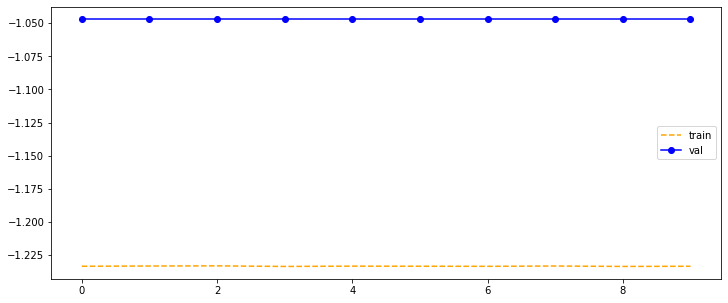

In [102]:
# Визуализация
def plot_loss(Loss_train, Loss_val):
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(Loss_train)), Loss_train, color='orange', label='train', linestyle='--')
    plt.plot(range(len(Loss_val)), Loss_val, color='blue', marker='o', label='val')
    plt.legend()
    plt.show()

plot_loss(clf.train_loss, clf.val_loss)

In [103]:
# Обучение с оптимизатором Adam 
params = {
    'dataset': MyDataset,
    'net': net,
    'epoch_amount': 10, 
    'learning_rate': 1e-3,
    'early_stopping': 25,
    'loss_f':  lrl,
    'optim': torch.optim.Adam,
}

clf_2 = Trainer(**params)
clf_2.fit(X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy())

Эпоха: 0 Loss_train: -1.2338661313192256, 0:00:48.117400 сек
Loss_val: -1.0470187664031982

Эпоха: 1 Loss_train: -1.233680725929821, 0:00:47.642116 сек
Loss_val: -1.0470187664031982

Эпоха: 2 Loss_train: -1.233743089714873, 0:00:47.922552 сек
Loss_val: -1.0470187664031982

Эпоха: 3 Loss_train: -1.2335790295403337, 0:00:48.699372 сек
Loss_val: -1.0470187664031982

Эпоха: 4 Loss_train: -1.2338808720147028, 0:00:49.087935 сек
Loss_val: -1.0470187664031982

Эпоха: 5 Loss_train: -1.233519485061745, 0:00:47.676040 сек
Loss_val: -1.0470187664031982

Эпоха: 6 Loss_train: -1.2338047633376754, 0:00:47.384848 сек
Loss_val: -1.0470187664031982

Эпоха: 7 Loss_train: -1.2338603071065009, 0:00:47.741193 сек
Loss_val: -1.0470187664031982

Эпоха: 8 Loss_train: -1.2335746354399149, 0:00:47.913094 сек
Loss_val: -1.0470187664031982

Эпоха: 9 Loss_train: -1.2333535280252017, 0:00:47.136308 сек
Loss_val: -1.0470187664031982



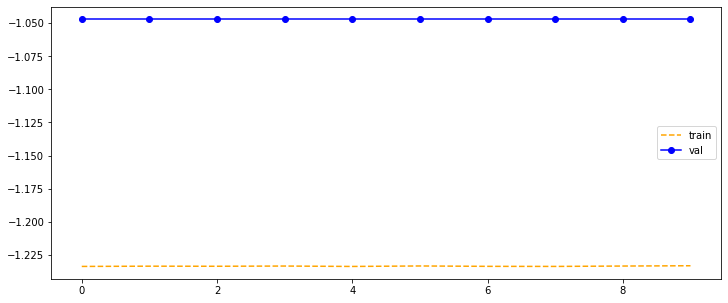

In [104]:
# Визуализация
plot_loss(clf_2.train_loss, clf_2.val_loss)

In [105]:
# Обучение с оптимизатором RMSprop 
params = {
    'dataset': MyDataset,
    'net': net,
    'epoch_amount': 10, 
    'learning_rate': 1e-3,
    'early_stopping': 25,
    'loss_f':  lrl,
    'optim': torch.optim.RMSprop,
}

clf_3 = Trainer(**params)
clf_3.fit(X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy())

Эпоха: 0 Loss_train: -1.2336507565046952, 0:00:45.002463 сек
Loss_val: -1.0470187664031982

Эпоха: 1 Loss_train: -1.2335755703668454, 0:00:44.723086 сек
Loss_val: -1.0470187664031982

Эпоха: 2 Loss_train: -1.2339440392920162, 0:00:44.718847 сек
Loss_val: -1.0470187664031982

Эпоха: 3 Loss_train: -1.2336273432792788, 0:00:44.933805 сек
Loss_val: -1.0470187664031982

Эпоха: 4 Loss_train: -1.2336241681310565, 0:00:44.358187 сек
Loss_val: -1.0470187664031982

Эпоха: 5 Loss_train: -1.2335042276596238, 0:00:48.692999 сек
Loss_val: -1.0470187664031982

Эпоха: 6 Loss_train: -1.2337573096781935, 0:00:47.746074 сек
Loss_val: -1.0470187664031982

Эпоха: 7 Loss_train: -1.2336795045081927, 0:00:47.521652 сек
Loss_val: -1.0470187664031982

Эпоха: 8 Loss_train: -1.2336158106803352, 0:00:46.991909 сек
Loss_val: -1.0470187664031982

Эпоха: 9 Loss_train: -1.2337177889707005, 0:00:48.027470 сек
Loss_val: -1.0470187664031982



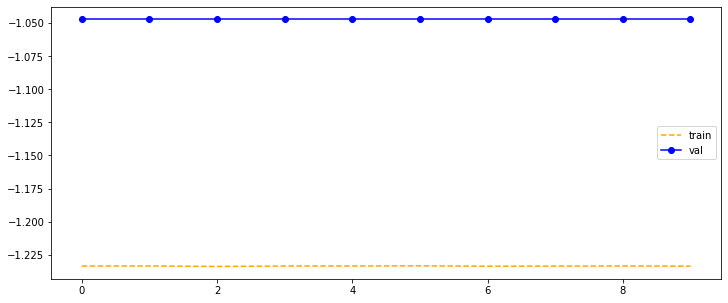

In [106]:
# Визуализация
plot_loss(clf_3.train_loss, clf_3.val_loss)

__Выводы:__

Применение различных оптимизаторов в процессе обучения модели не привела ни к каким изменениям.